# Scores

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from datetime import datetime
from kseval.models import basketball, tennis
from kseval.plotting import sigconf_settings
from kseval.utils import data_path
from matplotlib.dates import YearLocator, DateFormatter

In [3]:
sigconf_settings()

Sigconf settings loaded!


## Load data

**Basketball dataset**

- Golden State Warriors: `GSW`
- Los Angeles Lakers: `"GSW"`
- Chicago Bulls: `CHI`
- Boston Celtics: `BOS`
- Philadelphia 76ers: `PHI`

In [4]:
%%time
path = data_path("fig/basketball-matern32.pickle")
teams = ["GSW", "LAL", "CHI", "BOS", "PHI"]

if not os.path.exists(path):
    model = basketball.DynamicModel(nu="3/2", cvar=0.00259, dvar=0.13764, lscale=1.75309)
    model.fit()  # Takes ~2 min on my 2013 Apple MBP.
    with open(path, "wb") as f:
        pickle.dump({t: model.ks_model.item[t].fitter for t in teams}, f)
        
with open(path, "rb") as f:
    nba = pickle.load(f)

CPU times: user 10.3 ms, sys: 11 ms, total: 21.3 ms
Wall time: 20 ms


**Tennis dataset**

- Roger Federer
- Rafael Nadal
- Novak Djokovic
- Pete Sampras
- Andre Agassi
- Ivan Lendl
- Michael Chang
- Yevgeny Kafelnikov

In [5]:
%%time
path = data_path("fig/tennis-matern32.pickle")
players = [
    "Roger Federer", "Rafael Nadal", "Novak Djokovic", "Pete Sampras",
    "Andre Agassi", "Ivan Lendl", "Michael Chang", "Yevgeny Kafelnikov"
]

if not os.path.exists(path):
    model = tennis.DynamicModel(nu="3/2", cvar=0.03421, dvar=0.91246, lscale=7.46862)
    model.fit()  # /!\ Takes ~1h4m on my 2013 Apple MBP.
    with open(path, "wb") as f:
        pickle.dump({p: model.ks_model.item[p].fitter for p in players}, f)
        
with open(path, "rb") as f:
    atp = pickle.load(f)

CPU times: user 4.09 ms, sys: 3.61 ms, total: 7.7 ms
Wall time: 5.85 ms


## Plot scores

In [6]:
def plot_scores(fitters, items, ax, ncol=1):
    colors = iter(plt.cm.tab10(np.linspace(0, 1, 10)))
    first = min(f.ts.min() for f in fitters.values())
    last = max(f.ts.max() for f in fitters.values())
    resolution = 300 / (last - first)
    for name in items:
        color = next(colors)
        #first = min(obs.t for obs in model.item[name].observations)
        #last = max(obs.t for obs in model.item[name].observations)
        first = fitters[name].ts.min()
        last = fitters[name].ts.max()
        ts = np.linspace(first, last, num=int(resolution*(last - first)))
        ms, vs = fitters[name].predict(ts)
        std = np.sqrt(vs)
        ts = [datetime.fromtimestamp(t) for t in ts]
        ax.plot(ts, ms, color=color, label=name)
        ax.fill_between(ts, ms-std, ms+std, color=color, alpha=0.2, lw=0.5)
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend(frameon=True, edgecolor="white", ncol=ncol)

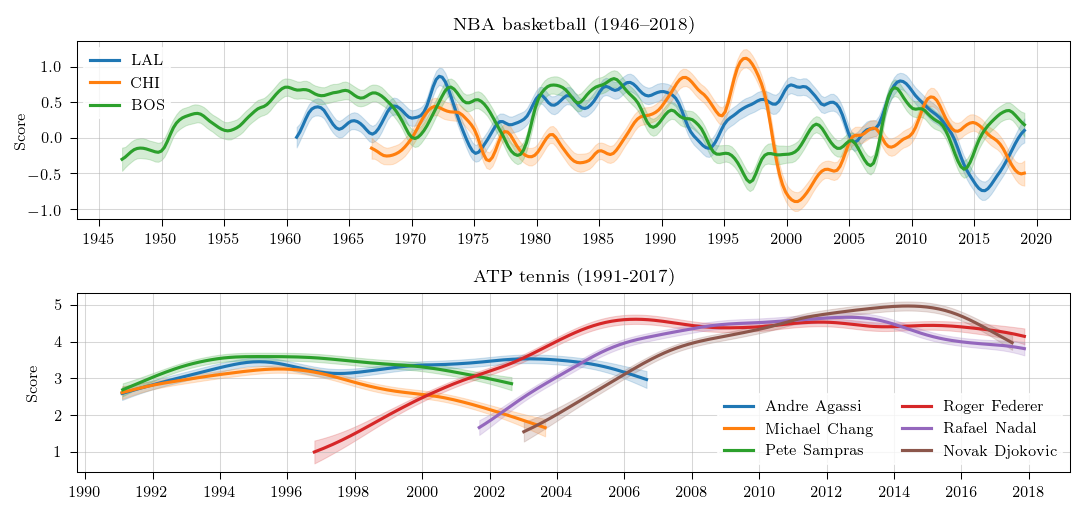

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(7.3, 3.5))
fmt = DateFormatter("%Y")

plot_scores(nba, ["LAL", "CHI", "BOS"], axs[0])
axs[0].xaxis.set_major_locator(YearLocator(base=5))
axs[0].xaxis.set_major_formatter(fmt)
axs[0].set_title("NBA basketball (1946–2018)")
axs[0].set_ylabel("Score", labelpad=0.0)

subset = ["Andre Agassi", "Michael Chang", "Pete Sampras", "Roger Federer", "Rafael Nadal", "Novak Djokovic"]
plot_scores(atp, subset, axs[1], ncol=2)
axs[1].xaxis.set_major_locator(YearLocator(base=2))
axs[1].xaxis.set_major_formatter(fmt)
axs[1].set_title("ATP tennis (1991-2017)")
axs[1].set_ylabel("Score", labelpad=7.0)
    
fig.tight_layout()
plt.savefig("scores.pdf", bbox_inches="tight")